# TokFSM Tutorial

This tutorial focuses on studying codebook models trained on an algorithmic sequence modeling dataset called TokFSM. The purpose of this dataset is to create a controlled setting exhibiting many of the complexities of language
modeling, but where the latent features present in the sequence are known. This enables us to
evaluate how well the model learns codes that activate on these distinct features.


### Setup

In [1]:
# this is done to load the fsm transition matrix saved in the repo
model_id = "TokFSM_k1_codebook_model"
! git clone https://huggingface.co/taufeeque/$model_id

fatal: destination path 'TokFSM_k1_codebook_model' already exists and is not an empty directory.


In [2]:
import plotly.express as px
import torch
import transformers
import numpy as np
import itertools
from codebook_features import models, run_clm, train_fsm_model, trainer as cb_trainer
from codebook_features import fsm_utils, utils as cb_utils
import os
import plotly.graph_objects as go
from functorch.dim import dims

# We turn automatic differentiation off, to save GPU memory,
# as this tutorial focuses only on model inference
torch.set_grad_enabled(False)

The TokFSM dataset is produced by first constructing a simplified finite state machine (FSM). Our FSM is defined by $(V, E)$ where $V = \{0...N-1\}$ is a set of nodes and $E \subseteq V \times V$ contains the probability that one state will transition to the next state in each iteration. In our setting, we choose $N=100$ and give each node 10 randomly chosen outbound neighbors, each of which is assigned an equal transition probability ($0.1$).

Here we specify the codebook model hyperparameters and the FSM parameters and load the FSM object.

In [3]:
# Hyperparameters
hp = dict(
    run_name="hooked_model_neox",
    tags=[],
    num_states=100,
    num_edges=10,
    seq_len=128,
    vocab_size=11,
    hidden_size=128,
    intermediate_size=512,
    num_hidden_layers=4,
    num_attention_heads=4,
    rotary_emb_base=10000,
)

device = "cuda"
config = transformers.GPTNeoXConfig(
    vocab_size=hp["vocab_size"],
    hidden_size=hp["hidden_size"],
    num_hidden_layers=hp["num_hidden_layers"],
    num_attention_heads=hp["num_attention_heads"],
    intermediate_size=hp["intermediate_size"],
    rotary_emb_base=hp["rotary_emb_base"],
    bos_token_id=hp["vocab_size"] - 1,
    eos_token_id=hp["vocab_size"] - 1,
    max_position_embeddings=hp["seq_len"],
)
config.architectures = ["GPTNeoXForCausalLM"]
model = transformers.GPTNeoXForCausalLM(config=config)
model = model.to(device).eval()
cb_model = models.wrap_codebook(
    model_or_path=model,
    pretrained_path=f"taufeeque/{model_id}",
)
cb_model = cb_model.to(device).eval()

In [4]:
# hooked model
hooked_kwargs = dict(
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=False,
    fold_value_biases=False,
    refactor_factored_attn_matrices=False,
    device=device,
)
hooked_model = models.convert_to_hooked_model_for_tokfsm(
    f"taufeeque/{model_id}",
    cb_model,
    config=config,
    hooked_kwargs=hooked_kwargs,
)
hooked_model = hooked_model.to(device).eval()
tokenizer = hooked_model.tokenizer

In [5]:
fsm = train_fsm_model.FSM.load(
    model_id + "/fsm.npy", representation_base=hp["vocab_size"] - 1, seed=42
)
tokfsm = train_fsm_model.TokFSMDataset(fsm, tokenizer=tokenizer, seq_len=hp["seq_len"])
print()
print("Number of states:", fsm.N)
print("Number of edges from every state:", fsm.edges)
print("A random trajectory in the FSM:")
traj = fsm.generate_trajectory(length=5)
print("state " + " -> state ".join(map(str, traj)))
print("Tokenized trajectory:")
print(tokenizer.encode(fsm.traj_to_str(traj)))


Number of states: 100
Number of edges from every state: 10
A random trajectory in the FSM:
state 8 -> state 53 -> state 75 -> state 61 -> state 2
Tokenized trajectory:
[0, 8, 5, 3, 7, 5, 6, 1, 0, 2]


### Load Codebook Model

To check that the codebook model is working, we can pass all possible states to the model and check the accuracy of the model on predicting the next states.

In [6]:
acc = fsm_utils.first_transition_accuracy(hooked_model, fsm)
print(f"Accuracy of the first transition: {(100*acc):.2f}%")

100%|██████████| 100/100 [00:15<00:00,  6.56it/s]

Accuracy of the first transition: 97.50%


### Code Purity wrt FSM states

We want to check how many codes learned by the codebook model only activate on a particular bigram or trigram. We call such codes "pure" codes. We can check this by passing all possible bigrams and trigrams to the codebook model and finding the fraction of codes that activated on a single bigram or trigram.

In [7]:
layer_purity_trigrams = []
layer_purity_bigrams = []
all_partitions2 = []
all_partitions3 = []
all_partitions_union = []
for layer in range(hooked_model.cfg.n_layers):
    partitions2 = fsm_utils.partition_input_on_codebook(
        hooked_model, fsm, cb_at="mlp", layer=layer, gcb_idx=None, input_len=2
    )
    pure = len([p for code, p in partitions2.items() if len(p) == 1])
    layer_purity_bigrams.append(pure / len(partitions2))

    partitions3 = fsm_utils.partition_input_on_codebook(
        hooked_model, fsm, cb_at="mlp", layer=layer, gcb_idx=None, input_len=3
    )
    pure = len([p for code, p in partitions3.items() if len(p) == 1])
    layer_purity_trigrams.append(pure / len(partitions3))

layer_purity_bigrams = [100 * x for x in layer_purity_bigrams]
layer_purity_trigrams = [100 * x for x in layer_purity_trigrams]

100it [00:01, 60.52it/s]
1000it [00:11, 87.82it/s]
100it [00:01, 61.71it/s]
1000it [00:11, 88.27it/s]
100it [00:01, 62.03it/s]
1000it [00:11, 87.32it/s]
100it [00:01, 54.67it/s]
1000it [00:11, 86.40it/s]


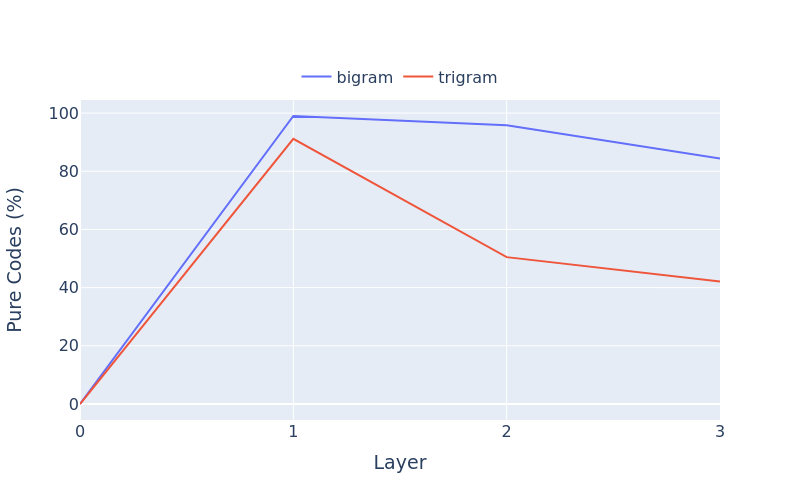

In [8]:
fig = go.Figure()
fig.add_scatter(
    x=list(range(hooked_model.cfg.n_layers)),
    y=layer_purity_bigrams,
    mode="lines",
    name="bigram",
)
fig.add_scatter(
    x=list(range(hooked_model.cfg.n_layers)),
    y=layer_purity_trigrams,
    mode="lines",
    name="trigram",
)
fig.update_xaxes(tick0=0, dtick=1)
fig.update_layout(
    xaxis_title="Layer",
    yaxis_title="Pure Codes (%)",
    font=dict(
        size=16,
    ),
    width=800,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="auto",
        x=0.5,
    ),
)
fig.show(renderer="png")

### State Code Intervention

We want to measure the causal effect of the codes on predicting the output distribution for bigrams (states) and trigrams. To do this, we pass some random state $S_a$ as the input and intervene with the code(s) at some components of another state $S_b$ and measure the JS divergence between the resulting output distribution and the original output distribution of $S_b$. We do this for all possible pairs of states $(S_a, S_b)$. We can then average the JS divergence over all pairs of states to get a measure of the causal effect of the code at different components on the output distribution.

In [9]:
import torch.nn.functional as F
from tqdm import tqdm


def generate_all_valid_inputs_with_prefix(
    fsm, is_trigram, prefix_random_states_len, seed=42
):
    assert prefix_random_states_len >= 0 and prefix_random_states_len <= 63
    rev_fsm = fsm.reverse()
    rng = np.random.default_rng(seed=seed)
    repeat = 3 if is_trigram else 2
    chars = [str(i) for i in range(fsm.representation_base)]
    all_valid_inputs = [
        "".join(comb)
        for comb in itertools.product(chars, repeat=repeat)
        if fsm_utils.valid_input("".join(comb), fsm)
    ]
    # if not is_trigram and prefix_random_states_len > 0:
    #     # if we are generating bigrams with random prefix, we can sample more random states
    #     all_valid_inputs = all_valid_inputs * 5
    all_valid_inputs_tokens = tokenizer(all_valid_inputs, return_tensors="pt")[
        "input_ids"
    ].to(hooked_model.cfg.device)
    start_states = [s[0] for s in fsm.seq_to_traj(all_valid_inputs)]
    random_state_prefix = rev_fsm.generate_trajectories(
        prefix_random_states_len, start_states=start_states
    )
    random_state_prefix = random_state_prefix[:, ::-1]
    random_state_prefix = random_state_prefix.astype(int)
    prefix_to_hide = rng.integers(
        0, prefix_random_states_len + 1, len(all_valid_inputs)
    )
    final_token_pos = 2 * (prefix_random_states_len - prefix_to_hide) + repeat
    final_token_pos = torch.tensor(final_token_pos, device=hooked_model.cfg.device)
    random_state_prefix = [
        fsm.traj_to_str(traj[prefix_to_hide[i] :])
        for i, traj in enumerate(random_state_prefix)
    ]
    all_valid_inputs_w_prefix = [
        random_state_prefix[i] + all_valid_inputs[i]
        for i in range(len(all_valid_inputs))
    ]
    all_valid_inputs_w_prefix_tokens = tokenizer(
        all_valid_inputs_w_prefix, padding=True, return_tensors="pt"
    )["input_ids"]
    all_valid_inputs_w_prefix_tokens = F.pad(
        all_valid_inputs_w_prefix_tokens, (1, 0), value=tokenizer.bos_token_id
    )
    all_valid_inputs_w_prefix_tokens = all_valid_inputs_w_prefix_tokens.to(device)

    return all_valid_inputs, all_valid_inputs_w_prefix_tokens, final_token_pos


(
    all_valid_inputs,
    all_valid_inputs_w_prefix_tokens,
    final_token_pos,
) = generate_all_valid_inputs_with_prefix(
    fsm,
    is_trigram=False,
    prefix_random_states_len=0,  # change to 62 to reproduce the results in the paper
)

js_divs = {}
all_state_info = {}
# store the logits and cache of all valid inputs without any random prefix.
for input in tqdm(all_valid_inputs):
    input_tensor = hooked_model.to_tokens(str(input), prepend_bos=True).to(device)
    logits, cache = hooked_model.run_with_cache(input_tensor)
    all_state_info[input] = (logits, cache)

for iter_a, input_a in enumerate(all_valid_inputs[: len(all_state_info)]):
    for input_b in all_valid_inputs[iter_a + 1 : len(all_state_info)]:
        js_divs[(input_a, input_b)] = cb_utils.JSD(
            all_state_info[input_a][0], all_state_info[input_b][0]
        ).item()

avg_js_div = sum(js_divs.values()) / len(js_divs)
all_states_logits = torch.cat([v[0] for v in all_state_info.values()], dim=0)

100%|██████████| 100/100 [00:01<00:00, 59.69it/s]


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


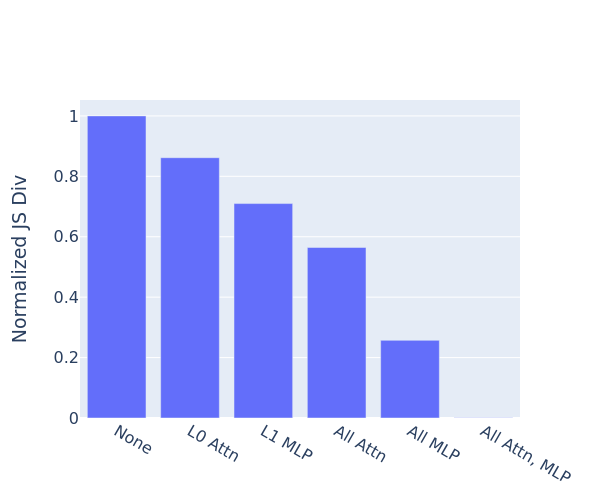

In [10]:
from functools import partial

patchings_to_plot_orig = [
    "none",
    "l0_attn",
    "l1_mlp",
    "all_attn",
    "all_mlp",
    "all_attn_mlp",
]
patchings_to_plot = [s.replace("all", "l0,l1,l2,l3") for s in patchings_to_plot_orig]

js_divs_for_patching = {k: 0 for k in patchings_to_plot}
js_divs_for_patching["none"] = 0

for state_b, input_b in tqdm(enumerate(all_valid_inputs), total=len(all_valid_inputs)):
    js_divs_w_b = cb_utils.JSD(
        all_states_logits[:, -1],
        all_states_logits[state_b % len(all_state_info), -1].unsqueeze(0),
        reduction="none",
    ).sum()
    js_divs_w_b /= all_states_logits.shape[0] - 1  # removing b as JSD(b,b) = 0
    js_divs_for_patching["none"] += js_divs_w_b

    for patching in patchings_to_plot:
        if patching == "none":
            continue
        cb_at = patching.split("_")[1:]
        layers = fsm_utils.get_layers_from_patching_str(patching)
        heads = [None] * len(cb_at)
        if "attn" in cb_at:
            attn_idx = cb_at.index("attn")
            cb_at.pop(attn_idx), heads.pop(attn_idx)
            cb_at += ["attn"] * hooked_model.cfg.n_heads
            heads += list(range(hooked_model.cfg.n_heads))
        cb_at_rep = cb_at * len(layers)
        heads_rep = heads * len(layers)
        layers_rep = []
        for l in layers:
            layers_rep += [l] * len(cb_at)

        cache_b = all_state_info[input_b][1]
        code = [
            cache_b[
                cb_utils.get_cb_hook_key(cb_at_rep[i], layers_rep[i], heads_rep[i])
            ][0, -1, :]
            for i in range(len(cb_at_rep))
        ]

        mod_logits, mod_cache = fsm_utils.run_with_codes_var_pos(
            all_valid_inputs_w_prefix_tokens,
            hooked_model,
            code,
            cb_at_rep,
            layers_rep,
            heads_rep,
            pos=final_token_pos,
        )
        a, b, c = dims(sizes=mod_logits.shape)
        mod_logits_final = mod_logits[a, final_token_pos[a], c].order(a, c)
        js_divs_w_b = cb_utils.JSD(
            mod_logits_final,
            all_states_logits[state_b % len(all_state_info), -1].unsqueeze(0),
            reduction="none",
        ).sum()
        js_divs_w_b /= mod_logits_final.shape[0] - 1  # removing b as JSD(b,b) = 0
        js_divs_for_patching[patching] += js_divs_w_b

js_divs_for_patching = [
    js_divs_for_patching[k].item() / len(all_valid_inputs) for k in patchings_to_plot
]
js_divs_for_patching = [
    js_div / max(js_divs_for_patching) for js_div in js_divs_for_patching
]

fig = go.Figure()
x_labels = [
    fsm_utils.clean_patching_name(patching) for patching in patchings_to_plot_orig
]
fig.add_trace(go.Bar(x=x_labels, y=js_divs_for_patching))
fig.update_layout(yaxis_title="Normalized JS Div")
fig.update_layout(
    width=600,
    font=dict(
        size=16,
    ),
)
fig.show(renderer="png")

As can be seen from the above bar charts, the L1 MLP code has a higher causal effect on the output distribution than the L1 attention code. This is consistent with our findings that the Layer 1 MLP code has a one-to-one mapping with the FSM states and the trigrams, while the Layer 1 attention code is more spread out.

To look at the tokens different codes from any layer activate on, play around with our webapp at: https://huggingface.co/spaces/taufeeque/codebook-features

### Inputs Grouped by Codes

In the later layers of the codebook model, the codes are not one-to-one with the FSM states, as is evident from the code purity plots. Multiple inputs are grouped together into a single code. One reason to group together different states within the last layer could be because they have the same next token.

We check this hypothesis by comparing the distance of the output distributions of random states with the distance of the output distributions of states grouped together by codes. If the hypothesis is true, we would expect the distance between the output distributions of states grouped together by codes to be ***smaller*** than the distance between the output distributions of random states.

In [11]:
chars = [str(i) for i in range(fsm.representation_base)]
all_valid_inputs2 = [
    "".join(comb)
    for comb in itertools.product(chars, repeat=3)
    if fsm_utils.valid_input("".join(comb), fsm)
]
js_divs2 = {}
for input in tqdm(all_valid_inputs2):
    input_tensor = hooked_model.to_tokens(str(input), prepend_bos=True).to(device)
    logits, cache = hooked_model.run_with_cache(input_tensor)
    all_state_info[input] = (logits, cache)

for iter_a, input_a in enumerate(all_valid_inputs2):
    for input_b in all_valid_inputs2[iter_a + 1 : len(all_state_info)]:
        js_divs2[(input_a, input_b)] = cb_utils.JSD(
            all_state_info[input_a][0], all_state_info[input_b][0]
        ).item()

code_groups_for_all_comps = {}
for layer in tqdm(range(hooked_model.cfg.n_layers)):
    code_groups_for_all_comps[
        (layer, "mlp", None)
    ] = fsm_utils.partition_input_on_codebook(
        cb_model=hooked_model,
        fsm=fsm,
        layer=layer,
        cb_at="mlp",
        gcb_idx=None,
        input_len=3,
    )

100%|██████████| 686/686 [00:12<00:00, 57.03it/s]
1000it [00:11, 84.55it/s]00<?, ?it/s]
1000it [00:11, 84.60it/s]11<00:35, 11.83s/it]
1000it [00:11, 84.36it/s]23<00:23, 11.83s/it]
1000it [00:11, 85.78it/s]35<00:11, 11.84s/it]
100%|██████████| 4/4 [00:47<00:00, 11.79s/it]


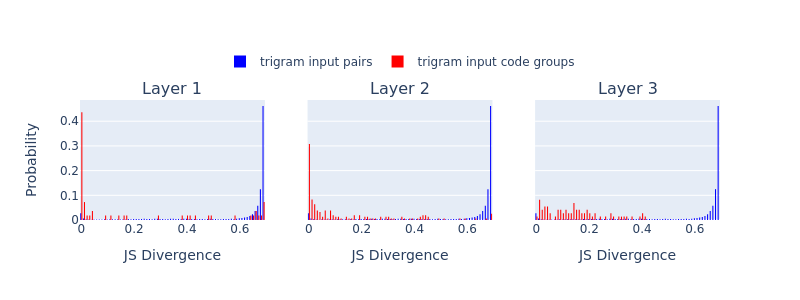

In [12]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1,
    cols=3,
    shared_yaxes=True,
    subplot_titles=[f"Layer {i}" for i in range(1, 4)],
)
fig.update_layout(title=None, width=800, height=300)
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.2,
        xanchor="auto",
        x=0.5,
    )
)

fig_kwargs = dict(row=1, col=1, showlegend=True)
fig = fsm_utils.plot_js_div(
    code_groups_for_all_comps, 1, "mlp", None, js_divs2, fig=fig, **fig_kwargs
)
fig_kwargs = dict(row=1, col=2, showlegend=False)
fig = fsm_utils.plot_js_div(
    code_groups_for_all_comps, 2, "mlp", None, js_divs2, fig=fig, **fig_kwargs
)
fig_kwargs = dict(row=1, col=3, showlegend=False)
fig = fsm_utils.plot_js_div(
    code_groups_for_all_comps, 3, "mlp", None, js_divs2, fig=fig, **fig_kwargs
)

fig.update_xaxes(title_text="JS Divergence")
fig.update_yaxes(title_text="Probability", row=1, col=1)
fig.show(renderer="png")

From the above plots we observe that the trigram inputs that are grouped together have a significantly smaller JS Divergence than the random trigram input pairs, which supports our hypothesis.